In [1]:
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt

# Problem setup

For a transducer, located at $x_t$, transmitting a monochromatic signal with wavenumber 

$$
k = \frac{2\pi f_0}{c_0}
$$

the pressure field at location $x_c$ is given by

$$
p_c = \frac{P_{ref}}{\|x_c - x_t\|}D(\theta)e^{j(k\|x_t-x_c\|+ \phi)}
$$

where

$$
D(\theta) = \frac{2J_1(k r \sin(\theta))}{k r \sin(\theta)}
$$

and $\theta$ is the angle between the transducer normal and $x_c$

In [2]:
# Free parameters
c0 = 346
f0 = 40e3
radius = 0.005
z_plane = 0.1
k = 2*jnp.pi*f0/c0

x_pos, y_pos = map(lambda x: (x-jnp.mean(x)).flatten()*radius, jnp.indices((32,32)))
z_pos = x_pos*0  # Tranducers on x_y plane
positions = jnp.stack([x_pos, y_pos, z_pos],axis=-1)
normals = (positions*0).at[:,2].set(1.) # All normals along the z axis -> (0,0,1)
phases = jnp.zeros((positions.shape[0],))

# Sampling positions
x_pos, y_pos = map(lambda x: (x-jnp.mean(x)).flatten()*radius/8, jnp.indices((256,256)))
z_pos = x_pos*0 + z_plane  # Tranducers on x_y plane
plane_positions = jnp.stack([x_pos, y_pos, z_pos],axis=-1)

Jax doesn't have built in the bessel function of first kind oder one ($J_1$). I don't totally trust my implementation of $J_1$, but the overall results should be more or less the same for small angles (far-field)

In [3]:
from jax.scipy import special

norm = lambda x: jnp.sqrt(jnp.sum(jnp.abs(x)**2))
avg_norm = lambda x: jnp.sqrt(jnp.mean(jnp.abs(x)**2))
dot = lambda x, y: jnp.sum(x*y)

def angle_between(x, y):
    return jnp.arccos(dot(x, y)/(norm(x)*norm(y)))

def J1(x):
    # call I1 the modified Bessel function of first kind order 1, 
    # then 
    # 
    # -J1(x) = grad(J0(x)) --> J1(x) = -grad(J0(x))
    # I0(x) = J0(ix) --> J0(x) = I0(-ix)
    #
    # is that correct?
    J0 = lambda x: jnp.i0(-1j*x)
    return -jax.grad(lambda x: J0(x))(x).real

def directivity_fun(theta):
    x = k*radius*jnp.sin(theta)
    D_with_nans = 2*J1(x)/x
    return jnp.where(jnp.isnan(D_with_nans), 1., D_with_nans)

def p_c(x_c, x_t, normal_vec, phase):
    theta = angle_between(x_c, normal_vec)
    D = directivity_fun(theta)
    dist = norm(x_c - x_t)
    output_phase = jnp.exp(1j*(k*dist + phase))
    return D*output_phase/dist

p_experiment = lambda xc, xt, n, phase: p_c(xc, xt, n, phase)

def p_tot(xc, xt, n, phases):
    return jnp.sum(
        jax.vmap(p_experiment, (None, 0, 0, 0), 0)(xc, xt, n, phases),
        0)

In [4]:
# Output for multiple sampling points
pc_vect = jax.vmap(p_tot, (0,None,None,None),0)

def get_hologram(x):
    return jnp.reshape(pc_vect(plane_positions, positions,normals,x), (256,256))

In [5]:
p = get_hologram(phases)
print("Oversampled field to test scalability. Number of grid points: {}".format(p.size))

Oversampled field to test scalability. Number of grid points: 65536


Text(0.5, 1.0, 'Beampattern in plane (x,y,0.1)')

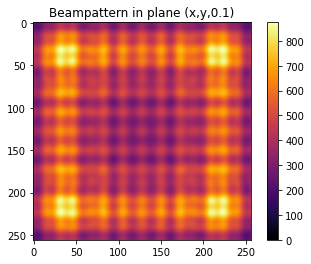

In [6]:
plt.imshow(jnp.abs(p), vmin=0, cmap="inferno")
plt.colorbar()
plt.title("Beampattern in plane (x,y,0.1)")

Defining loss function and optimization loop

In [7]:
from tqdm import tqdm
from jax.experimental import optimizers
from jax import random

Text(0.5, 1.0, 'Target')

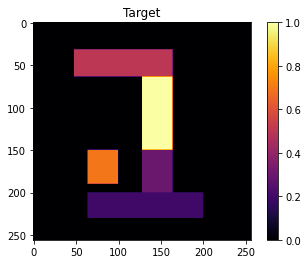

In [8]:
reference_hologram = jnp.zeros((256,256))
reference_hologram = reference_hologram.at[32:64,48:164].set(.5)
reference_hologram = reference_hologram.at[64:200,128:164].set(1.)
reference_hologram = reference_hologram.at[96:128,164:150].set(1.)
reference_hologram = reference_hologram.at[150:210,128:164].set(.3)
reference_hologram = reference_hologram.at[150:190,64:100].set(.7)
reference_hologram = reference_hologram.at[200:230,64:200].set(.2)
plt.imshow(reference_hologram, cmap="inferno")
plt.colorbar()
plt.title("Target")

In the paper the minimize the MSE wrt the target hologram, but I think that without careful scaling of the reference image intensity it is hard to converge to a low loss.

I instead maximize the correlation coefficient between the two images.

In [9]:
def xcorr(a,b):
    return -dot(a,b)/(norm(a)*norm(b))

def lossfun(x):
    return xcorr(jnp.abs(get_hologram(x)), reference_hologram)
    #return jnp.mean(jnp.abs(jnp.abs(get_hologram(x)) - reference_hologram))

loss_with_grad = jax.value_and_grad(lossfun)

In [10]:
losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.2)
opt_state = init_fun(phases)

@jax.jit
def update(opt_state, key, iteration):
    params = get_params(opt_state)
    lossval, gradient = loss_with_grad(params)
    return lossval, update_fun(iteration, gradient, opt_state)

In [11]:
pbar = tqdm(range(int(100)))
key = random.PRNGKey(42)

for iteration in pbar:
    _, key = random.split(key)
    lossval, opt_state = update(opt_state, key, iteration)
    
    # For logging
    new_phases = get_params(opt_state)
    losshistory.append(-lossval)
    
    pbar.set_description("Loss: {}".format(lossval))

Loss: -0.9548566341400146: 100%|██████████| 100/100 [00:04<00:00, 23.70it/s]


Text(0.5, 1.0, 'Optimized beampattern (hologram), plane (x,y,0.1)')

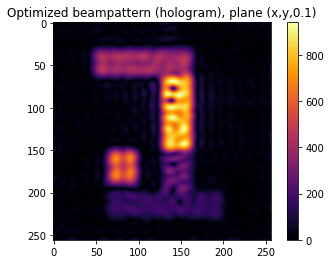

In [12]:
p = get_hologram(new_phases)
plt.imshow(jnp.abs(p), vmin=0, cmap="inferno")
plt.colorbar()
plt.title("Optimized beampattern (hologram), plane (x,y,0.1)")

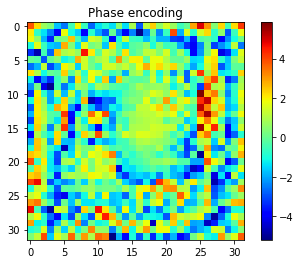

In [13]:
plt.imshow(jnp.reshape(new_phases,(32,32)), cmap="jet")
plt.title("Phase encoding")
plt.colorbar()

(0.4, 1.0)

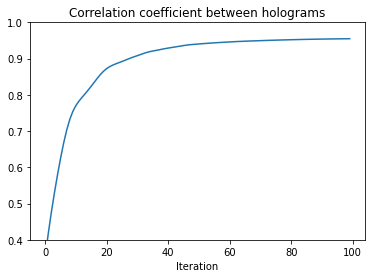

In [14]:
plt.plot(losshistory)
plt.title("Correlation coefficient between holograms")
plt.xlabel("Iteration")
plt.ylim([0.4,1])